In [1]:
#!pip install plotly
#!pip install googlemaps
#!pip install transliterate
#!pip install wordcloud

In [73]:
import os
import os.path
import pandas as pd
import numpy as np
import datetime
import matplotlib
import pickle
import json
import googlemaps
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import seaborn as sns
from matplotlib import pyplot as plt
import transliterate as ts
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
%matplotlib inline

In [2]:
mapbox_access_token = open('../mapbox_token.txt', 'r').read()
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)

In [3]:
DATA_PATH = 'C://Users//Matan//Desktop//Avito'

In [4]:
DATA_PATH = '/Users/ilaif/Desktop/data/avito'
HELPER_DATA_PATH = './helper_data'

In [5]:
# test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), parse_dates=['activation_date'])

In [6]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), parse_dates=['activation_date'])

# Translation

In [18]:
for col_name in ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3']:
    trans_dict = json.load(open(os.path.join(HELPER_DATA_PATH, col_name + '_en.json'), 'r'))
    train[col_name + '_en'] = train[col_name].apply(lambda t: trans_dict[t] if not pd.isnull(t) else t)

# Basic Feature Understanding

# <span style="color:blue">train.csv</span>

In [19]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability',
       'has_description', 'has_price', 'has_params', 'has_image',
       'parent_category_name_en', 'category_name_en', 'param_1_en',
       'param_2_en', 'param_3_en'],
      dtype='object')

In [20]:
train.head(10)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,deal_probability,has_description,has_price,has_params,has_image,parent_category_name_en,category_name_en,param_1_en,param_2_en,param_3_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,0.12789,True,True,True,True,Personal things,Goods for children and toys,Bed dress,NaN,NaN
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,0.00000,True,True,True,True,For home and cottages,Furniture and interior,Other,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,0.43177,True,True,True,True,Consumer electronics,Audio and video,"Video, DVD and Blu-ray players",NaN,NaN
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,0.80323,True,True,True,True,Personal things,Goods for children and toys,Car seats,NaN,NaN
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,0.20797,True,True,True,True,Transport,Cars,With mileage,VAZ (LADA),2110
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,...,0.80323,True,True,True,True,Personal things,Goods for children and toys,Car seats,NaN,NaN
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,...,0.00000,True,True,True,True,For home and cottages,Repair and construction,Plumbing and sauna,NaN,NaN
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,...,0.80323,True,True,True,True,Personal things,"Clothes, shoes, accessories",Women&#39;s clothing,Jeans,26
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,...,0.00000,True,True,True,True,Personal things,"Clothes, shoes, accessories",Women&#39;s clothing,Dresses and skirts,&gt; 50 (XXL)
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,...,0.00000,True,True,True,True,Personal things,Children&#39;s clothing and footwear,For girls,Footwear,25


We can see lots of NAN values in the params columns. Also we have lots of string columns(which are in Russian).

In [21]:
np.sum(train.isnull())/train.shape[0]*100

item_id                     0.000000
user_id                     0.000000
region                      0.000000
city                        0.000000
parent_category_name        0.000000
category_name               0.000000
param_1                     4.095718
param_2                    43.536753
param_3                    57.373369
title                       0.000000
description                 7.734079
price                       5.677839
item_seq_number             0.000000
activation_date             0.000000
user_type                   0.000000
image                       7.488772
image_top_1                 7.488772
deal_probability            0.000000
has_description             0.000000
has_price                   0.000000
has_params                  0.000000
has_image                   0.000000
parent_category_name_en     0.000000
category_name_en            0.000000
param_1_en                  4.095718
param_2_en                 43.536753
param_3_en                 57.373369
d

We need to handle this missing values. Large portion of them are in the param_2 and param_3 columns.
It might be interesting to study the items that has NAN values. Let's create boolean features for them:

In [22]:
train['has_description'] = train['description'].notna()
train['has_price'] = train['price'].notna()
train['has_params'] = train['param_1'].notna()
train['has_image'] = train['image'].notna()

## Users

In [23]:
print(train.user_id.value_counts(),train.user_id.value_counts().describe(),sep = "\n\n")

45ba3f23bf25    1080
ee74bccca74f     980
60dfed1efb6e     907
b239811ad530     840
abcdd1ca1a5c     807
82348911d21c     752
a2ef0215eec3     695
b5003ea27e7a     684
2cd9f03d6527     657
82a96987d0f8     636
33d09dfdbd90     523
41f112adb74b     512
da6e825c0fdb     508
ac2280e23cbe     492
4bdf52a81f23     410
03082624a937     396
762434c0fd7e     382
743f3355d84a     370
4d2eb0bfc2a4     366
c2920abccec4     363
c337541311f8     361
9bdc2002bf51     360
818d647950cc     359
dc757d764977     355
1e19ac0f143f     354
838127830416     342
6be8de23ae72     340
b2f33d77e08a     340
b6f2091f0c0c     330
c4723507345b     329
                ... 
8cfff81be520       1
1f12b47e20fe       1
c88d9675d0a1       1
ff0a37481d64       1
0fb9b3e7dd4f       1
6b71164d0426       1
8201fc955eae       1
c345ae8e6043       1
8c72e9933147       1
1dbb1d83184a       1
200b364d2cdf       1
74a8c824b63f       1
62a44abc2662       1
63fd099bb118       1
0c3c3e258056       1
3e2ae7cca3d6       1
d476723d5650 

Most users appear once, but we have some outliers.
Let's check the correlation between the user count and the target variable:

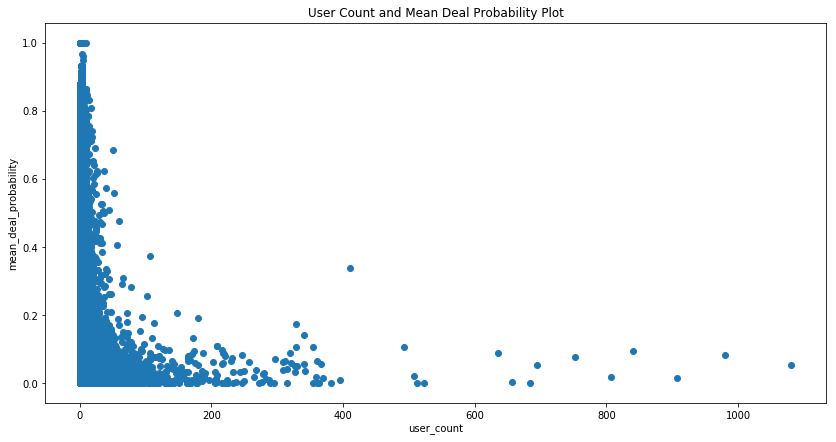

In [24]:
check = train[['user_id','deal_probability']]
user_mean = check.groupby('user_id').mean()
user_mean = user_mean.rename(columns = {'deal_probability' : 'mean_deal_probability'})
user_count = check.groupby('user_id').count()
user_count = user_count.rename(columns = {'deal_probability' : 'user_count'})
new_df = user_mean.join(user_count)
plt.scatter(new_df['user_count'], new_df['mean_deal_probability'])
plt.title("User Count and Mean Deal Probability Plot")
plt.xlabel("user_count")
plt.ylabel("mean_deal_probability")
plt.show()


In [25]:
print(new_df.corr())
print(new_df.corr('spearman'))
print(new_df.corr('kendall'))

                       mean_deal_probability  user_count
mean_deal_probability               1.000000   -0.055582
user_count                         -0.055582    1.000000
                       mean_deal_probability  user_count
mean_deal_probability               1.000000   -0.036278
user_count                         -0.036278    1.000000
                       mean_deal_probability  user_count
mean_deal_probability                1.00000    -0.03134
user_count                          -0.03134     1.00000


In [26]:
power_users = new_df[(new_df.mean_deal_probability >= 0.4) & (new_df.user_count > 10) ]
print(power_users.sort_values(by = 'mean_deal_probability' , ascending = False).head(10))
weak_users = new_df[(new_df.mean_deal_probability <=0.05) & (new_df.user_count > 10) ]
print(weak_users.sort_values(by = 'mean_deal_probability' , ascending = True).head(10))

              mean_deal_probability  user_count
user_id                                        
1e385206d244               0.847509          11
cc64f7af92b1               0.833261          14
813caaee2df7               0.809858          17
9b3d419e34b5               0.785030          11
55c1e63aa8b0               0.785030          12
389a4c70a84c               0.785029          12
8b07fb855dd3               0.754731          14
9872399c0349               0.741417          18
f3d5d5dd61ec               0.728956          14
d5d20e58d6d6               0.726449          11
              mean_deal_probability  user_count
user_id                                        
4d8ebeb108ec                    0.0          11
61d48ebafbea                    0.0          11
61d4b0ef0694                    0.0          12
61d8ab6b1032                    0.0          11
bd14b235d185                    0.0          16
bd0438832fe1                    0.0          17
6214c3049fc6                    0.0     

In [27]:
# Add a boolean feature for power users and weak users:
index_1 = list(power_users.index)
train['is_power_user'] = np.isin(train['user_id'], index_1)
print(train[train['is_power_user'] == True].shape[0]/ train.shape[0]*100)

0.15504608147801285


In [28]:
index_2 = list(weak_users.index)
train['is_weak_user'] = np.isin(train['user_id'], index_2)
print(train[train['is_weak_user'] == True].shape[0]/ train.shape[0]*100)

9.643254331446085


We can see that there are some interesting users which has really high deal probability or 0 deal probability. It might be helpfull to study them.
Let's see their user_type distribution first:

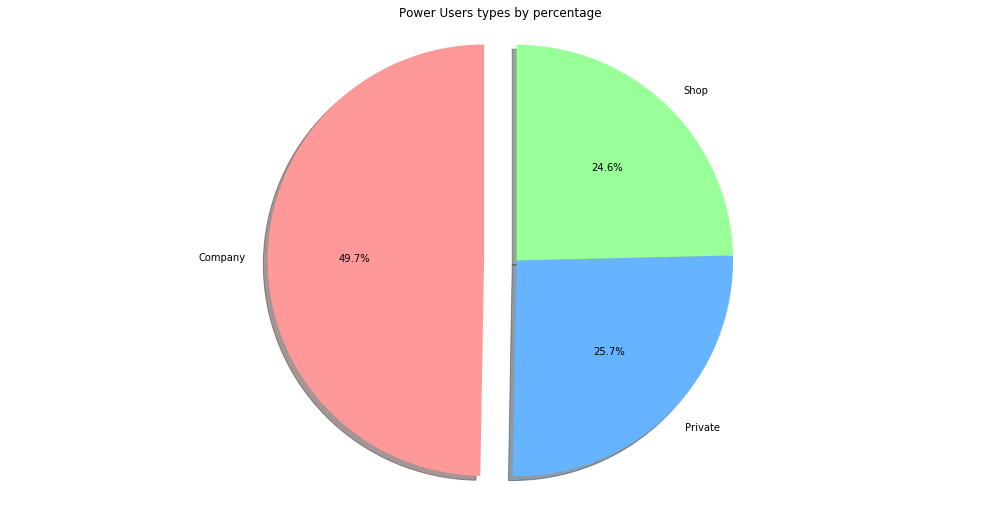

In [29]:
check = train[['user_id', 'user_type']]
check.set_index('user_id', inplace = True)
user_type_dist = power_users.join(check).groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Power Users types by percentage')
plt.show()

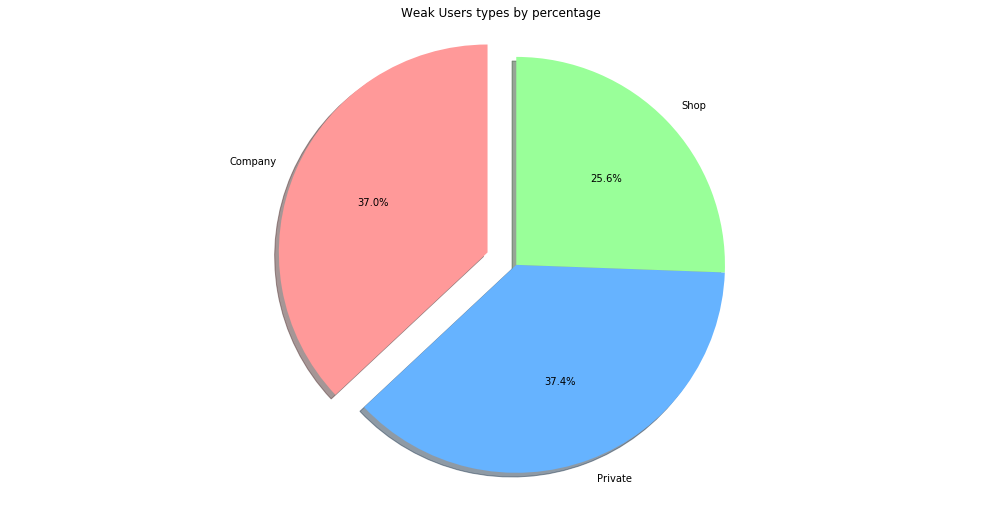

In [30]:
check = train[['user_id', 'user_type']]
check.set_index('user_id', inplace = True)
user_type_dist = weak_users.join(check).groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Weak Users types by percentage')
plt.show()

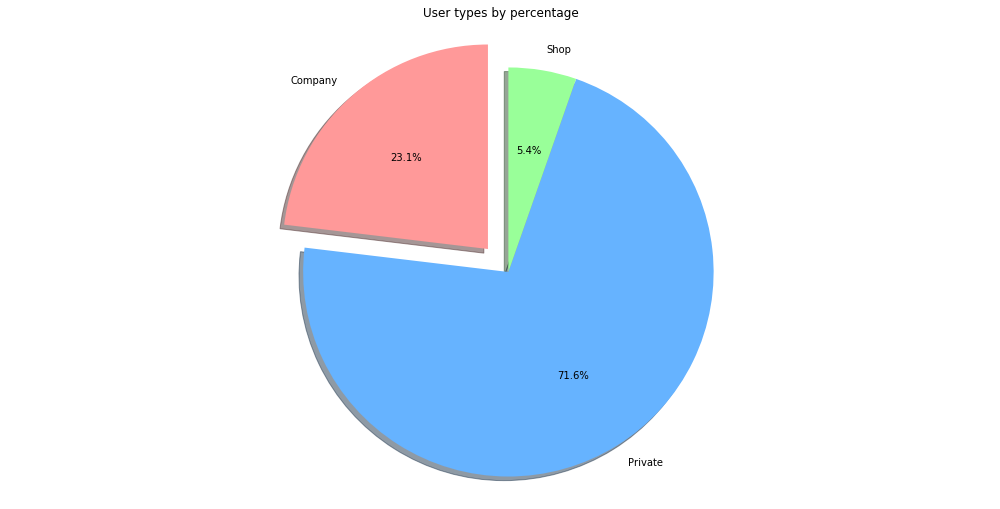

In [31]:
user_type_dist = train.groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('User types by percentage')
plt.show()

In [32]:
print(train.groupby('user_type')['deal_probability'].mean())

user_type
Company    0.124513
Private    0.149557
Shop       0.062829
Name: deal_probability, dtype: float64


We can see that over 70% of the items are from private users.
Also, shops have only 5% of the items and their deal_probability is significantly low.
We can also see that the 'power users' we found have a significantly different user_type distribution - almost 50% of them are companies and 25% of them are shops.
The 'weak users' also have different distribution - 37% of them are comapnies,37% of them are private and 25% are shops.

## Probability and Price by Region and City

Number of regions: 28


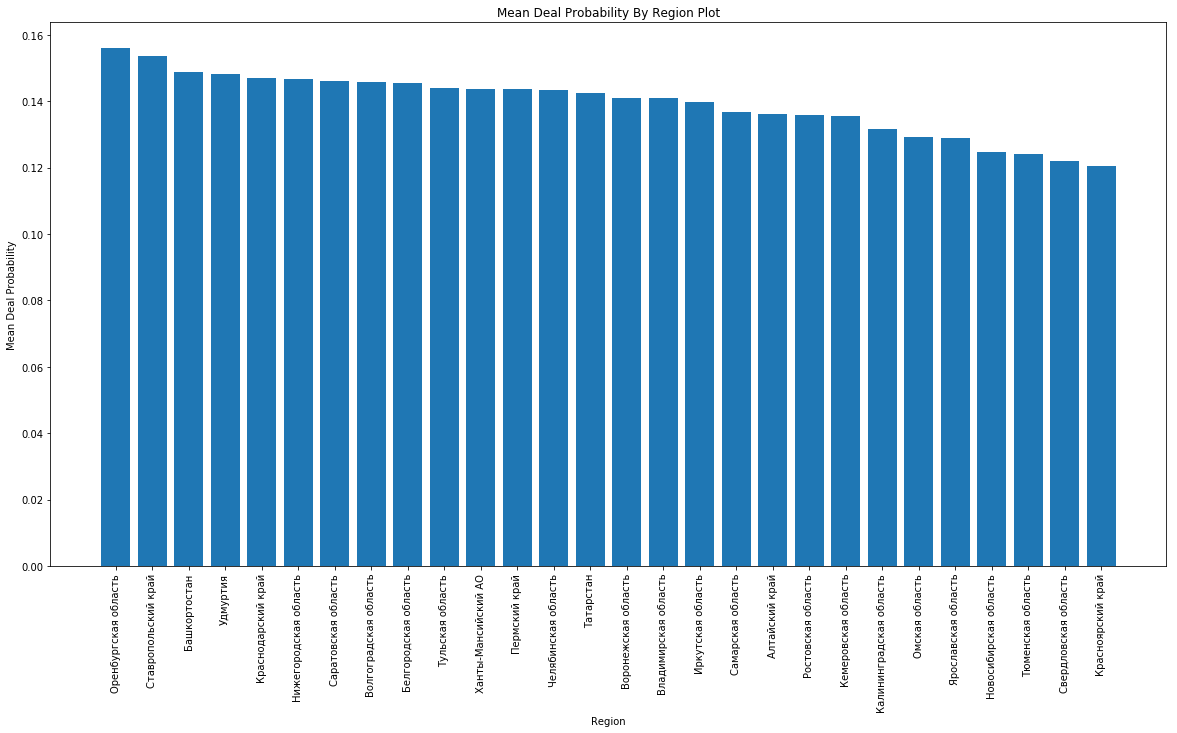

In [33]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print('Number of regions:', train['region'].nunique())
mean_deal_prob = train.groupby('region')['deal_probability'].mean().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(mean_deal_prob.index, mean_deal_prob.values)
plt.title('Mean Deal Probability By Region Plot')
plt.xlabel('Region')
plt.ylabel('Mean Deal Probability')
plt.show()

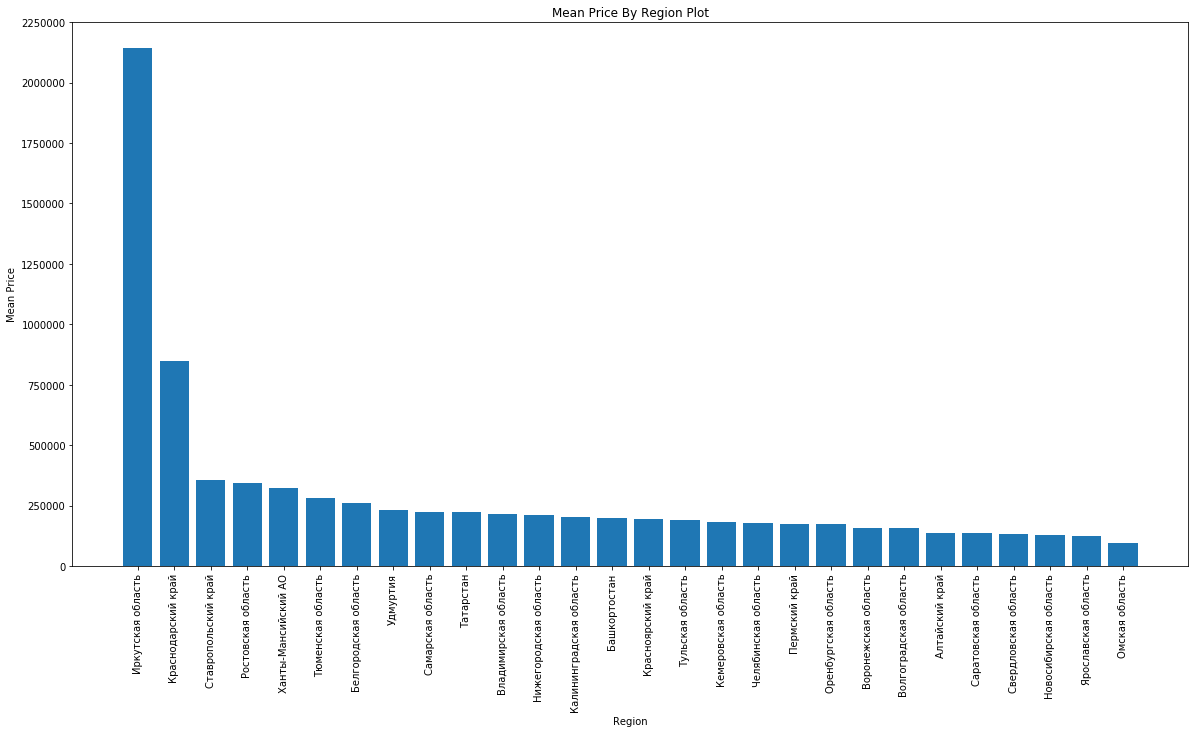

In [34]:
mean_price = train.groupby('region')['price'].mean().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(mean_price.index, mean_price.values)
plt.title('Mean Price By Region Plot')
plt.xlabel('Region')
plt.ylabel('Mean Price')
plt.show()

### Top 3 regions by mean_price:

In [35]:
print(mean_price.head(3))

region
Иркутская область      2.141739e+06
Краснодарский край     8.466639e+05
Ставропольский край    3.557127e+05
Name: price, dtype: float64


We can see that there isn't much of a connection between the region and the deal probabilty.
We also see that there are 2 regions with really high mean_price in comparison to the other regions.

Number of cities: 1733


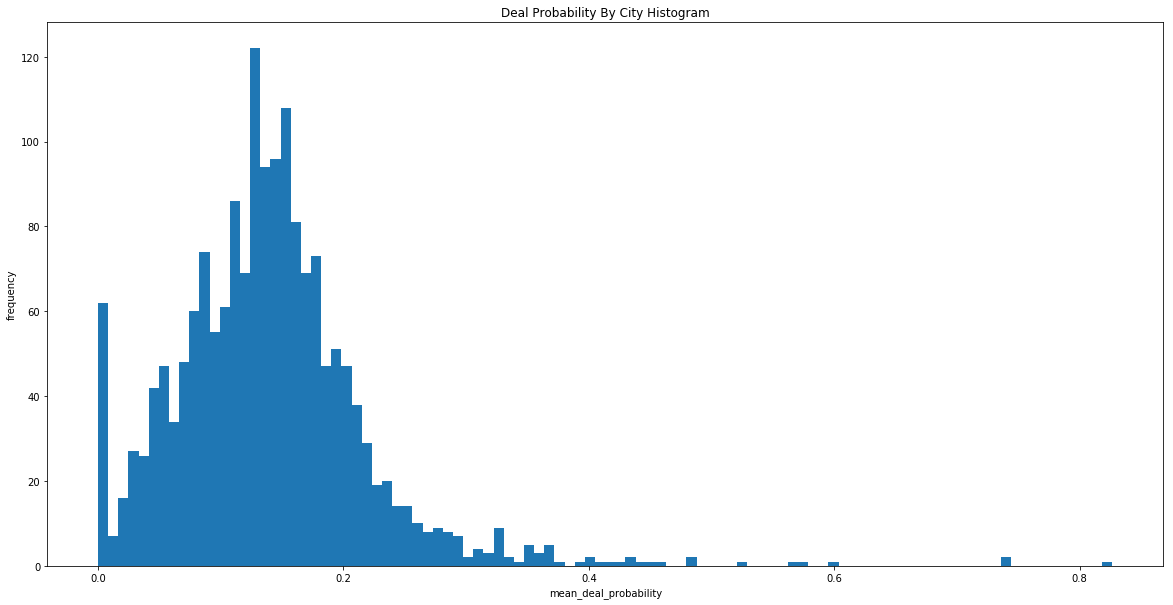

In [36]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print('Number of cities:', train['city'].nunique())
mean_deal_prob = train.groupby('city')['deal_probability'].mean().sort_values(ascending=False)
plt.hist(mean_deal_prob, bins = 100)
plt.title("Deal Probability By City Histogram")
plt.xlabel("mean_deal_probability")
plt.ylabel("frequency")
plt.show()

### Top 5 cities by mean_deal_probablility:

In [37]:
print(mean_deal_prob.head(5))

city
Приволжский      0.826680
Матмасы          0.737600
Виля             0.737600
Быстрогорский    0.595410
Бурлацкое        0.571207
Name: deal_probability, dtype: float64


We found some cities with really high deal_probability. Let's check if there are cities with high prbability and at least 10 itmes:

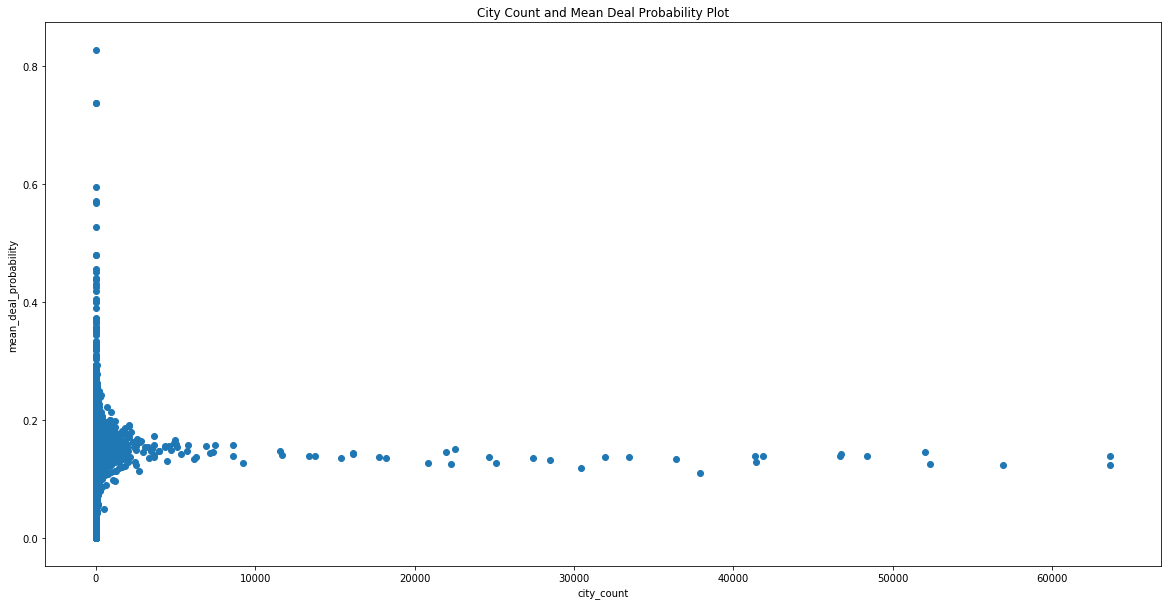

In [38]:
check = train[['city','deal_probability']]
city_mean = check.groupby('city').mean()
city_mean = city_mean.rename(columns = {'deal_probability' : 'mean_deal_probability'})
city_count = check.groupby('city').count()
city_count = city_count.rename(columns = {'deal_probability' : 'city_count'})
new_df = city_mean.join(city_count)
plt.scatter(new_df['city_count'], new_df['mean_deal_probability'])
plt.title("City Count and Mean Deal Probability Plot")
plt.xlabel("city_count")
plt.ylabel("mean_deal_probability")
plt.show()

In [39]:
outliers = new_df[(new_df.mean_deal_probability >= 0.4) & (new_df.city_count > 10) ]
print(outliers.sort_values(by = 'mean_deal_probability' , ascending = False))

Empty DataFrame
Columns: [mean_deal_probability, city_count]
Index: []


We can see that there aren't any interesting cities. (by our definition)

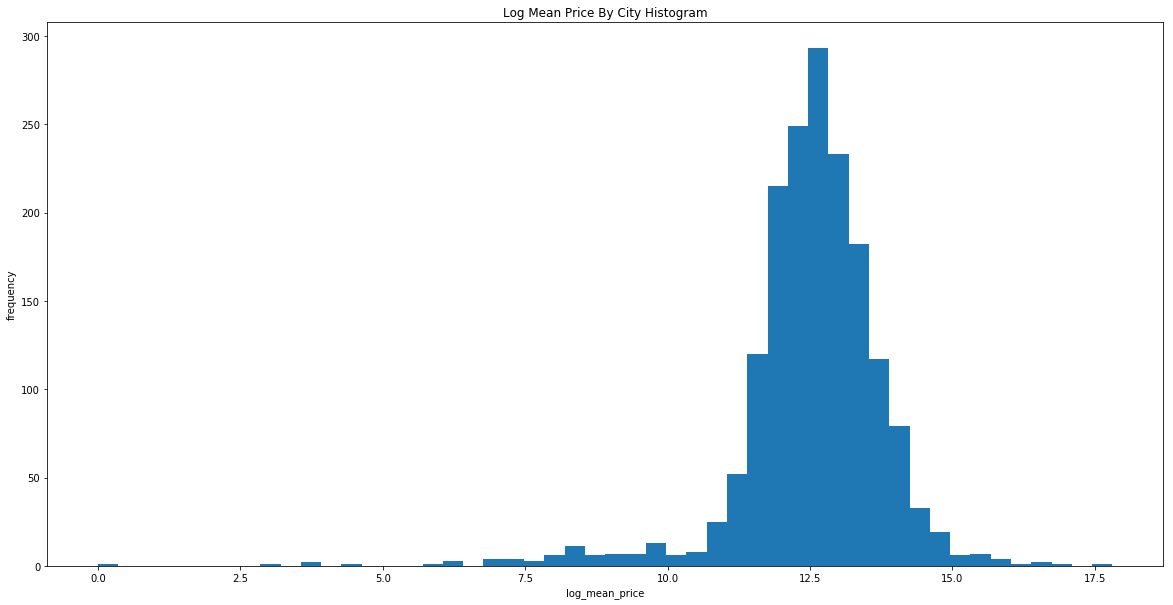

In [40]:
mean_price = train.groupby('city')['price'].mean().sort_values(ascending=False)
mean_price.dropna(inplace = True)
log_mean_price = np.log(mean_price)
plt.hist(log_mean_price, bins = 50)
plt.title("Log Mean Price By City Histogram")
plt.xlabel("log_mean_price")
plt.ylabel("frequency")
plt.show()

### Top 5 cities by log_mean_price:

In [41]:
print(log_mean_price.head(5))

city
Усолье-Сибирское    17.809099
Черноерковская      17.034386
Сокур               16.647370
Дмитриевка          16.523569
Ишня                16.108045
Name: price, dtype: float64


We can see that the log of the mean price histogram is close to a normal distribution (with mean = 12.5)

## Categories

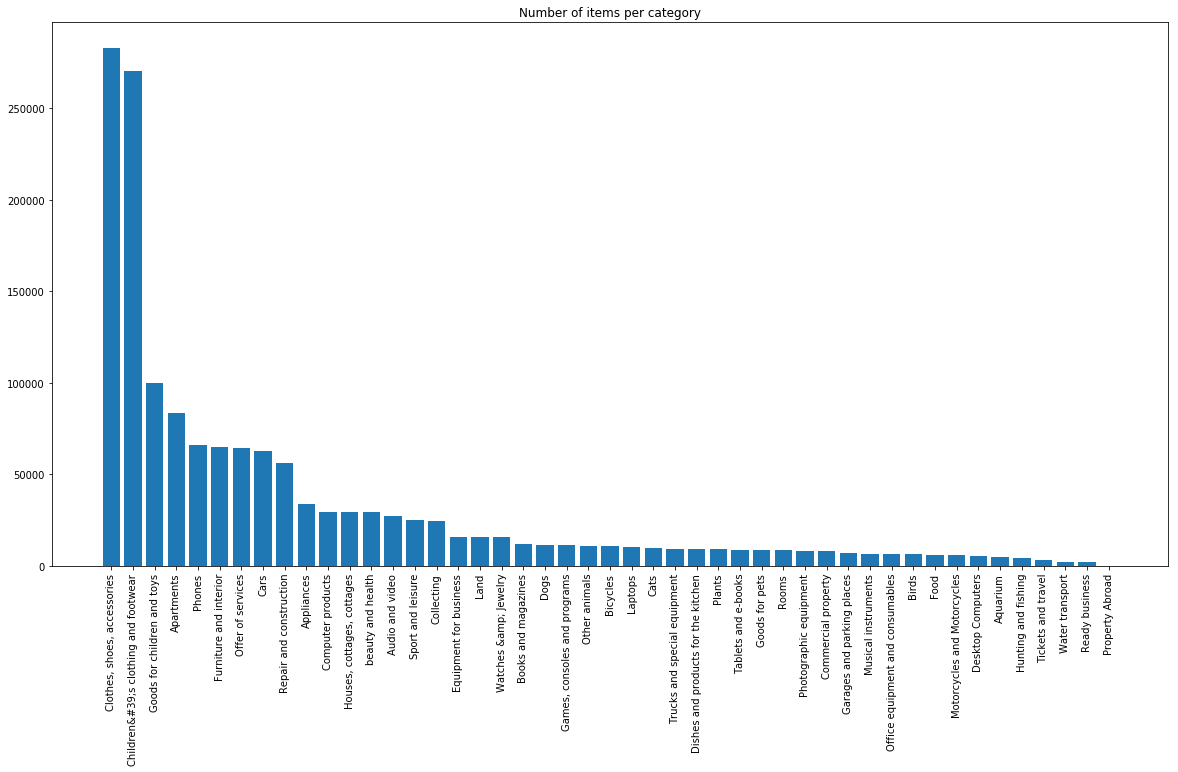

In [42]:
category_counts = train.groupby('category_name_en')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per category')
plt.show()

### Top 5 categories by count:

In [43]:
print(category_counts.head(5))

category_name_en
Clothes, shoes, accessories             282753
Children&#39;s clothing and footwear    270359
Goods for children and toys              99747
Apartments                               83670
Phones                                   65944
Name: item_id, dtype: int64


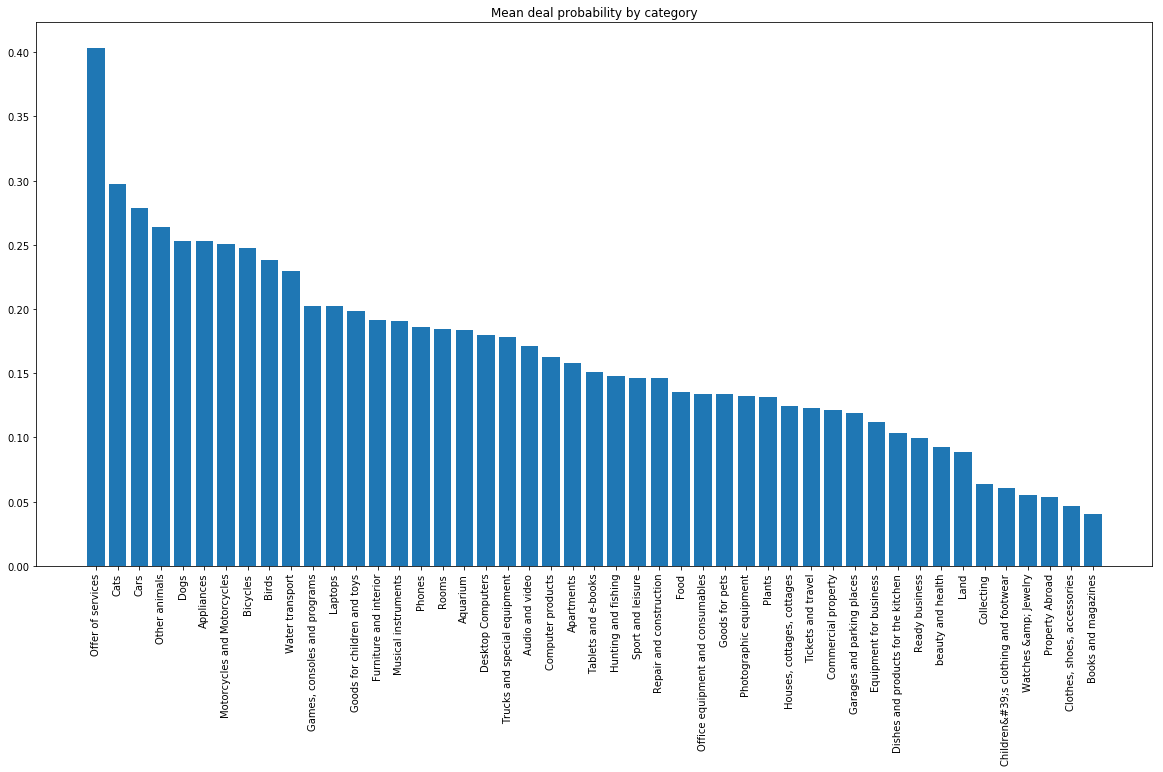

In [44]:
mean_deal_prob = train.groupby('category_name_en')['deal_probability'].mean().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(mean_deal_prob.index, mean_deal_prob.values)
plt.title('Mean deal probability by category')
plt.show()

### Top 5 categories by mean_deal_probability:

In [45]:
print(mean_deal_prob.head(5))

category_name_en
Offer of services    0.403123
Cats                 0.297259
Cars                 0.278427
Other animals        0.264051
Dogs                 0.252812
Name: deal_probability, dtype: float64


We can see that most items are from the 'Children's clothing and footwear' category and the 'clothes,shoes,accessories'.
We can  also see that the 'Offer of services' category has really high deal_probability (0.4) and the 'cars' cetegory and some animal categories also has relatively high deal_probability. 

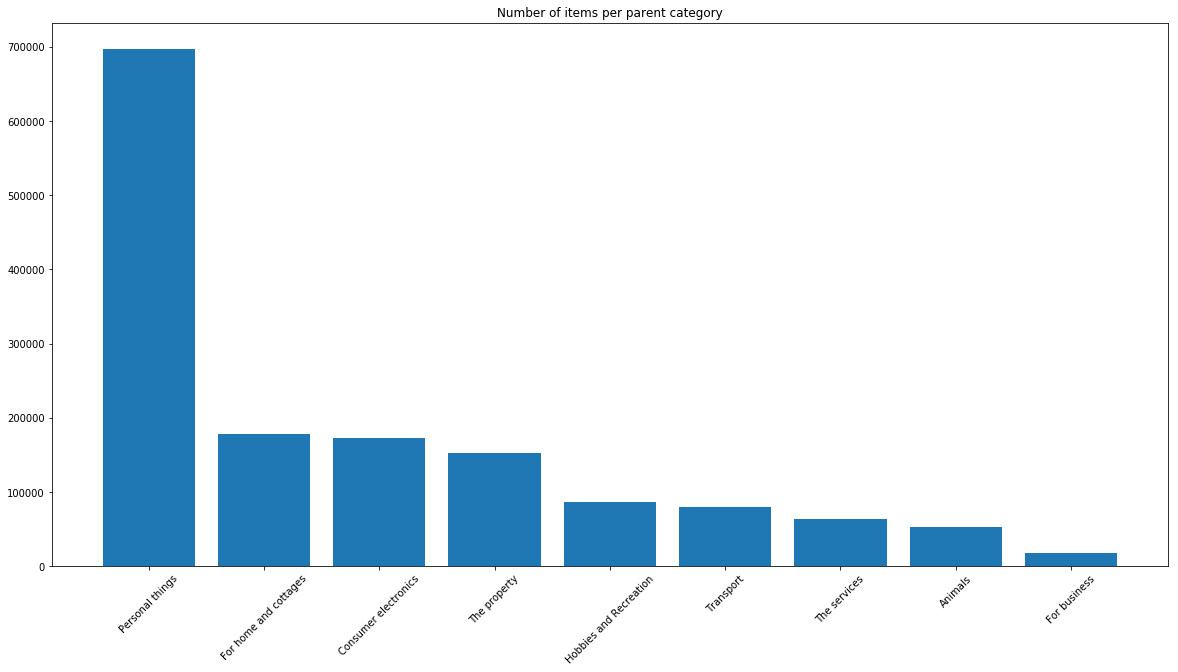

In [46]:
parent_category_counts = train.groupby('parent_category_name_en')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(parent_category_counts.index, parent_category_counts.values)
plt.title('Number of items per parent category')
plt.show()

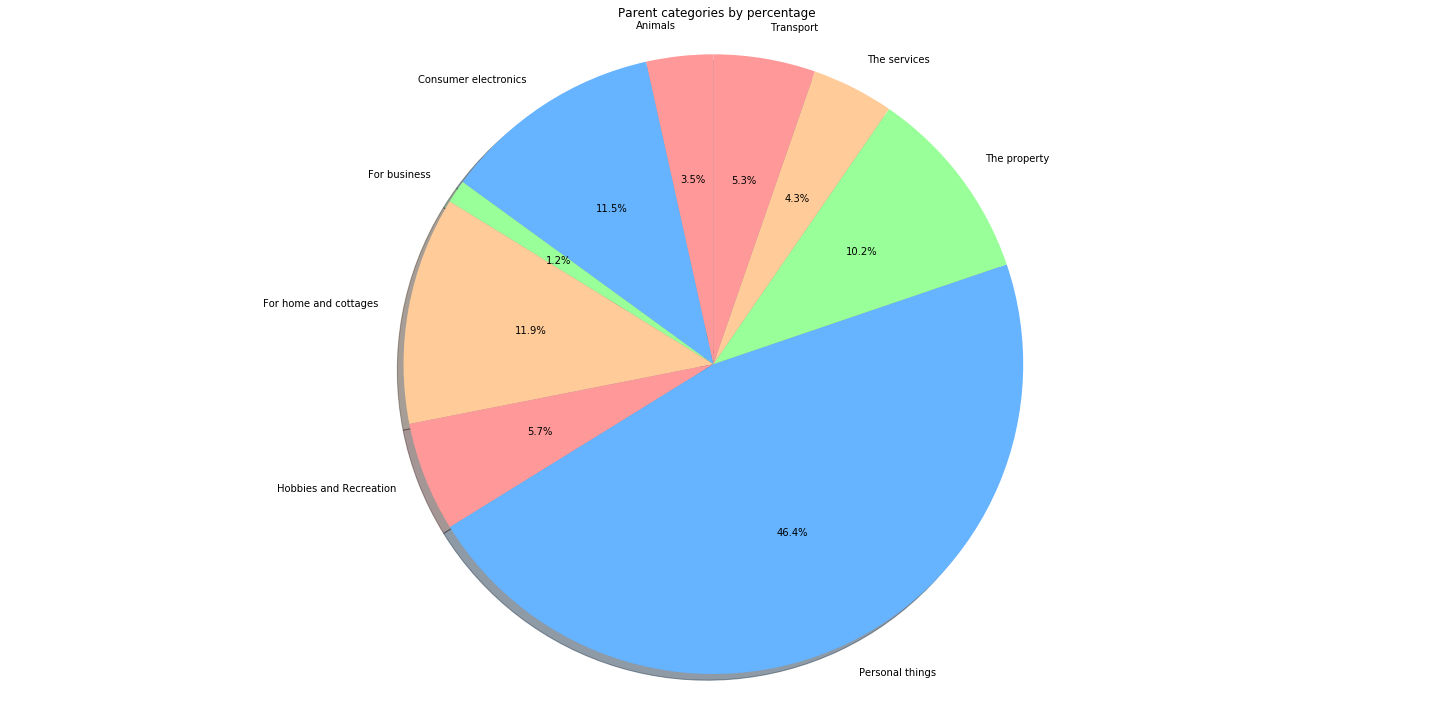

In [47]:
parent_category_dist = train.groupby('parent_category_name_en').size()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = parent_category_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(parent_category_dist, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Parent categories by percentage')
plt.show()

### Top 3  parent categories by count:

In [48]:
print(parent_category_counts.head(3))

parent_category_name_en
Personal things          697623
For home and cottages    178823
Consumer electronics     173008
Name: item_id, dtype: int64


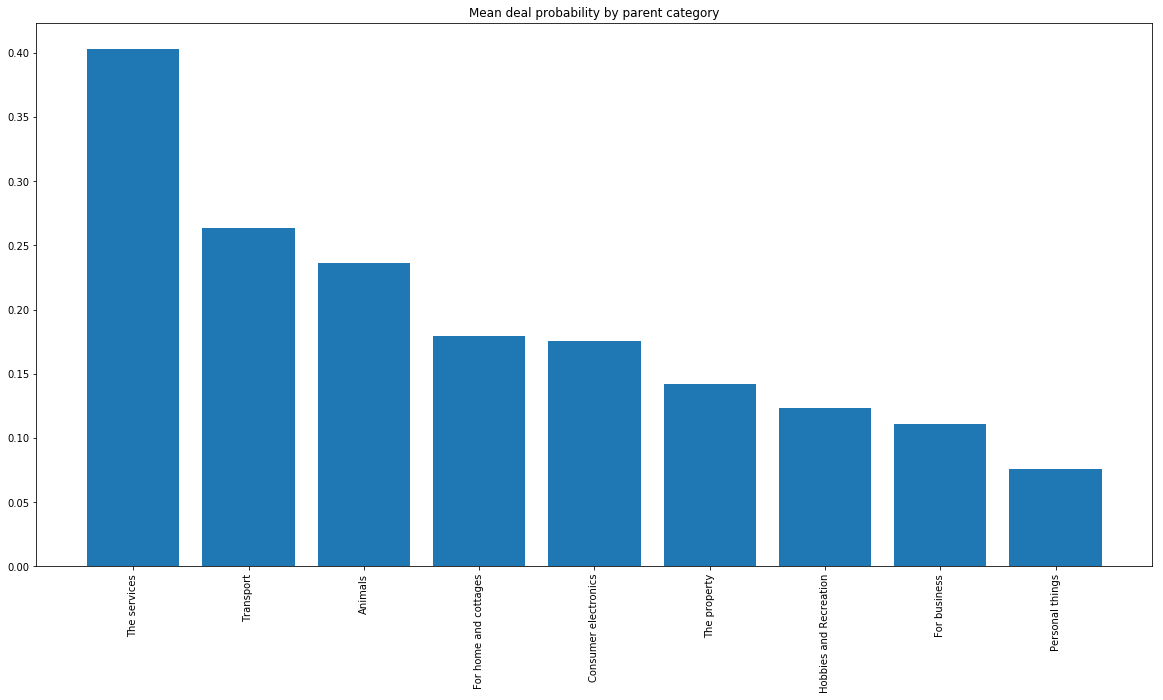

In [49]:
mean_deal_prob = train.groupby('parent_category_name_en')['deal_probability'].mean().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(mean_deal_prob.index, mean_deal_prob.values)
plt.title('Mean deal probability by parent category')
plt.show()

### Top 3 parent categories by mean_deal_probability:

In [50]:
print(mean_deal_prob.head(3))

parent_category_name_en
The services    0.403123
Transport       0.263336
Animals         0.235957
Name: deal_probability, dtype: float64


We can see that large majority (almost 50%) of items are from the 'Personal things' parent category.
We can also see that 'The services', 'Transport' and 'Animals' parent categories have the highest deal_probability (but there aren't many items from those categories)

## Images

Number of image_top_1 values: 771769


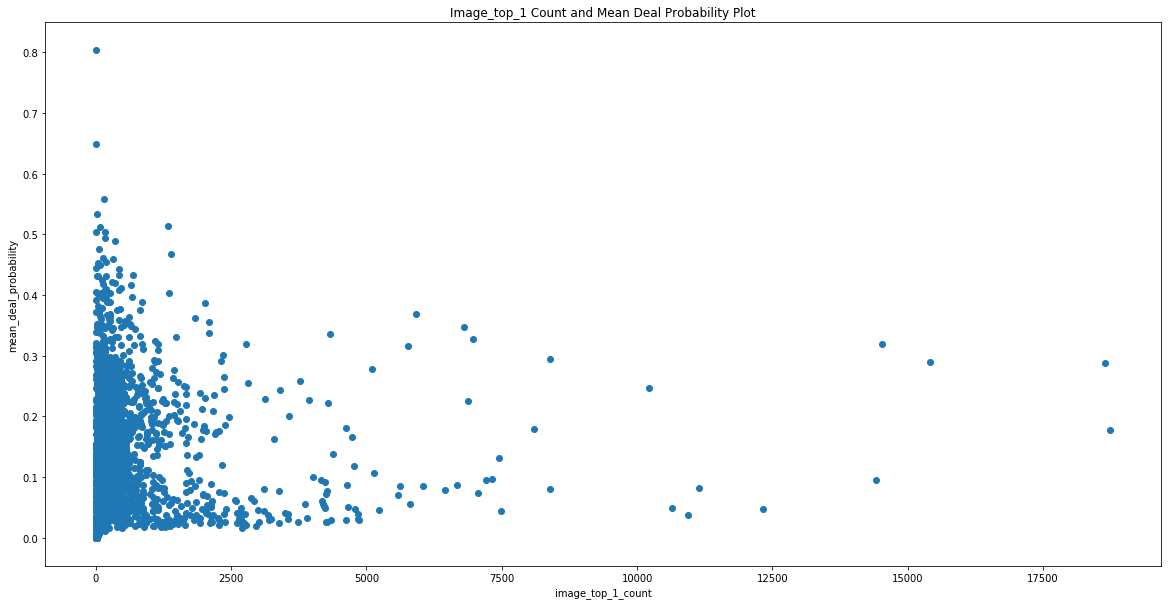

In [51]:
print('Number of image_top_1 values:', train['user_id'].nunique())
check = train[['image_top_1','deal_probability']]
image_top_1_mean = check.groupby('image_top_1').mean()
image_top_1_mean = image_top_1_mean.rename(columns = {'deal_probability' : 'mean_deal_probability'})
image_top_1_count = check.groupby('image_top_1').count()
image_top_1_count = image_top_1_count.rename(columns = {'deal_probability' : 'image_top_1_count'})
new_df = image_top_1_mean.join(image_top_1_count)
plt.scatter(new_df['image_top_1_count'], new_df['mean_deal_probability'])
plt.title("Image_top_1 Count and Mean Deal Probability Plot")
plt.xlabel("image_top_1_count")
plt.ylabel("mean_deal_probability")
plt.show()

### Correlation between image_top_1 value and deal_probability:

In [52]:
print(check.corr())

                  image_top_1  deal_probability
image_top_1          1.000000          0.189979
deal_probability     0.189979          1.000000


### Correlation between image_top_1 count and mean_deal_probability:

In [53]:
print(new_df.corr())

                       mean_deal_probability  image_top_1_count
mean_deal_probability                1.00000            0.00289
image_top_1_count                    0.00289            1.00000


In [54]:
power_images = new_df[(new_df.mean_deal_probability >= 0.4) & (new_df.image_top_1_count  > 10) ]
print(power_images.sort_values(by = 'mean_deal_probability' , ascending = False).head(10))

             mean_deal_probability  image_top_1_count
image_top_1                                          
1796.0                    0.558288                147
1844.0                    0.533462                 33
1784.0                    0.514011               1334
1851.0                    0.512150                 85
1804.0                    0.504322                172
1808.0                    0.494134                168
1846.0                    0.489233                360
1850.0                    0.476196                 55
2275.0                    0.468331               1393
1853.0                    0.461065                142


In [55]:
# Add a boolean feature for power images:
index_1 = list(power_images.index)
train['is_power_image'] = np.isin(train['image_top_1'], index_1)
print(train[train['is_power_image'] == True].shape[0]/ train.shape[0]*100)

0.7389133072240432


## Dates

In [56]:
train['weekday'] = train.activation_date.dt.weekday
train['month'] = train.activation_date.dt.month
train['day'] = train.activation_date.dt.day

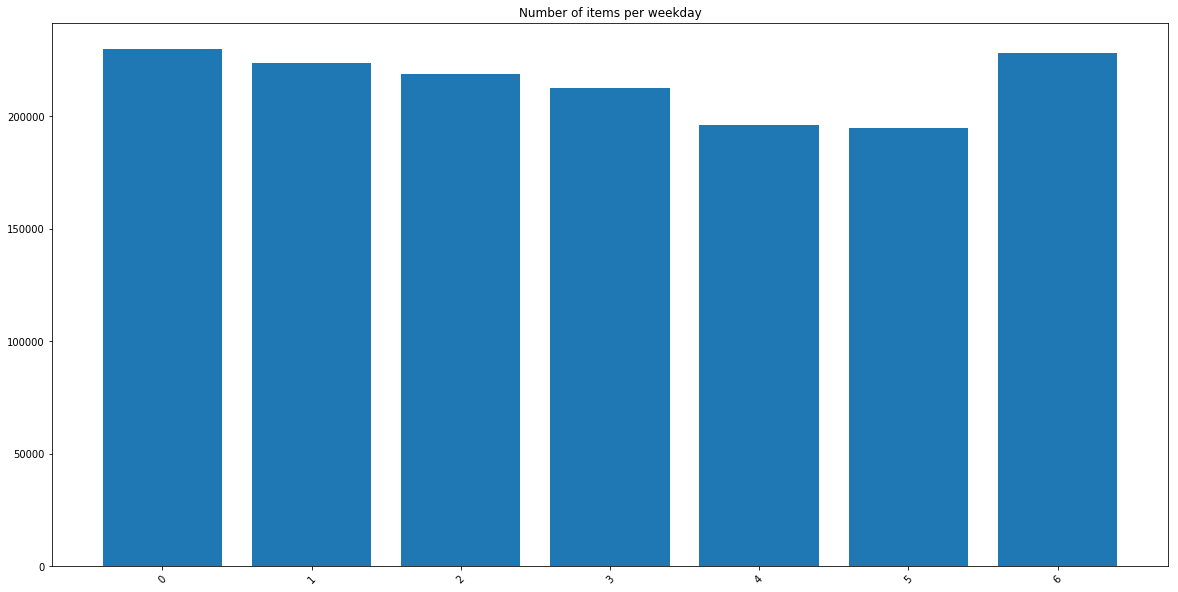

In [57]:
weekday_counts = train.groupby('weekday')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(weekday_counts.index, weekday_counts.values)
plt.title('Number of items per weekday')
plt.show()
# 0 is Monday, 6 is Sunday

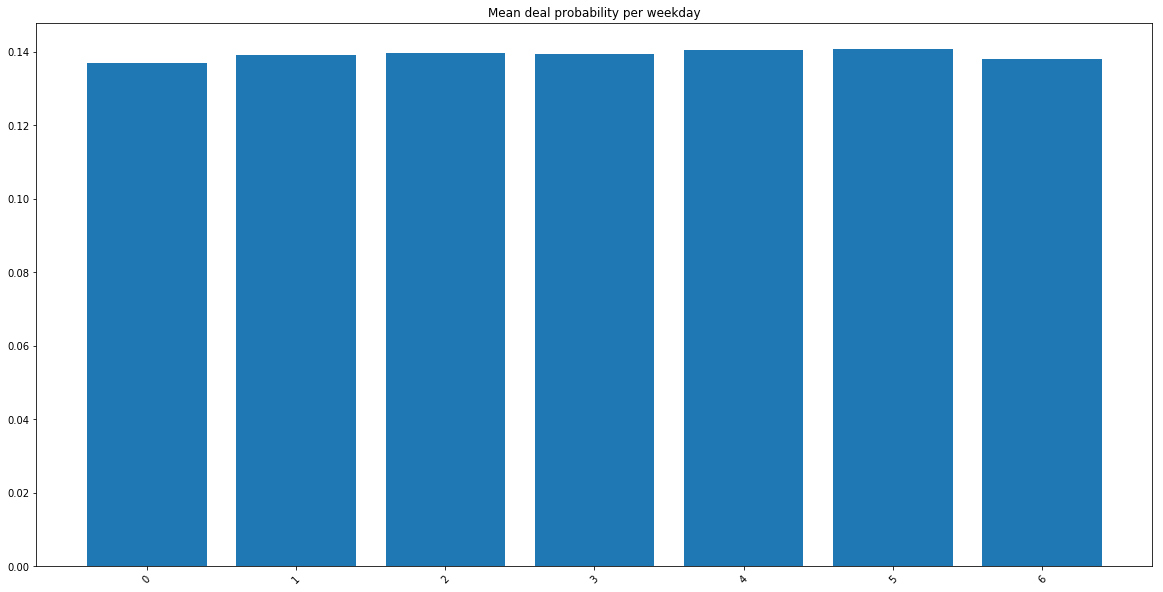

In [58]:
weekday_deal_prob = train.groupby('weekday')['deal_probability'].mean().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(weekday_deal_prob.index, weekday_deal_prob.values)
plt.title('Mean deal probability per weekday')
plt.show()

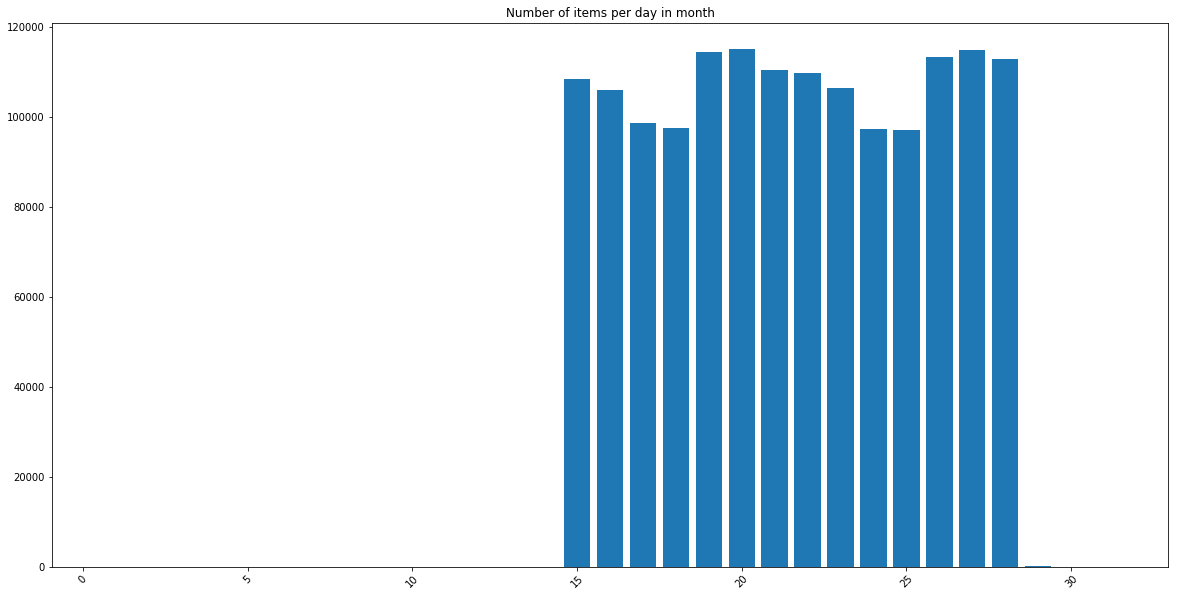

In [59]:
day_counts = train.groupby('day')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(day_counts.index, day_counts.values)
plt.title('Number of items per day in month')
plt.show()

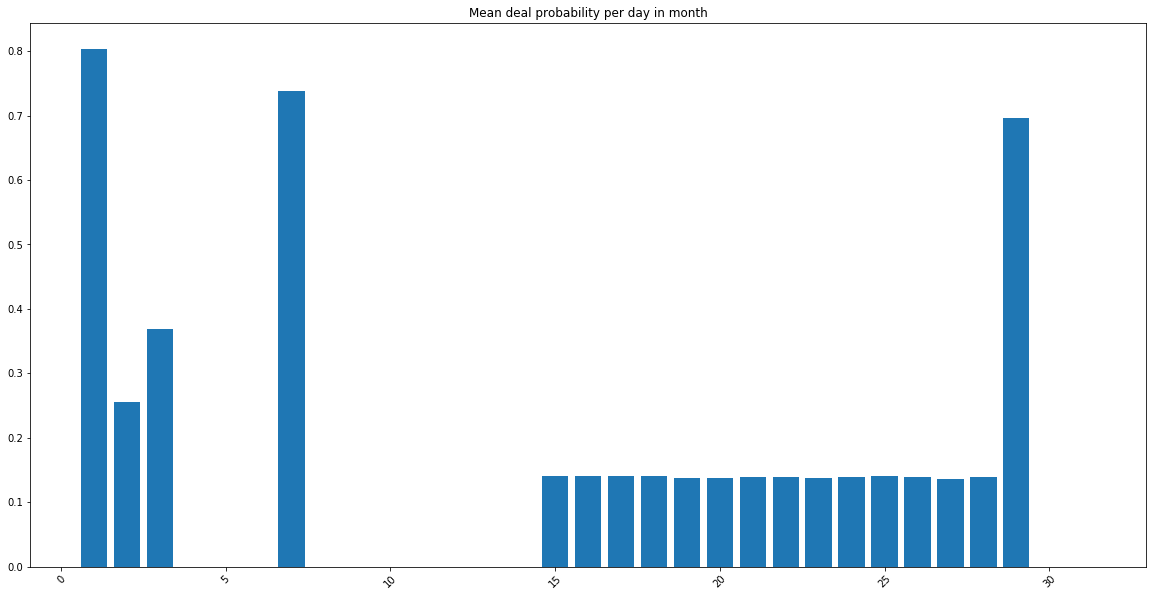

In [60]:
day_deal_prob = train.groupby('day')['deal_probability'].mean().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(day_deal_prob.index, day_deal_prob.values)
plt.title('Mean deal probability per day in month')
plt.show()

We can see that there isn't much to deduce from the date feature regarding the target variable

## Title and Description

In [61]:
# from wordcloud import WordCloud
# import random
# txt = " ".join(train.title)
# def blue_color(word, font_size, position, orientation, random_state=None, **kwargs):
#     return 'hsl({:d}, 80%, {:d}%)'.format(random.randint(180, 200), random.randint(60, 80))
# wordcloud1 = WordCloud(max_font_size=50, width=500, height=300).generate(txt)
# plt.figure(figsize=(16,8))
# plt.imshow(wordcloud1.recolor(color_func=blue_color, random_state=3),interpolation="bilinear")
# plt.axis("off")
# plt.show() 

## Params

## Deal Classes

In [62]:
deal_class_1 = train[(0 <= train['deal_probability']) &  (train['deal_probability'] < 0.2)]
deal_class_2 = train[(0.2 <= train['deal_probability']) &  (train['deal_probability'] < 0.4)]
deal_class_3 = train[(0.4 <= train['deal_probability']) &  (train['deal_probability'] < 0.6)]
deal_class_4 = train[(0.6 <= train['deal_probability']) &  (train['deal_probability'] < 0.8)]
deal_class_5 = train[(0.8 <= train['deal_probability']) &  (train['deal_probability'] <= 1)]

deal_class_1 percentage of values:  78.0099293346388 and mean price is:  353864.1274646506
Pearson correlation:


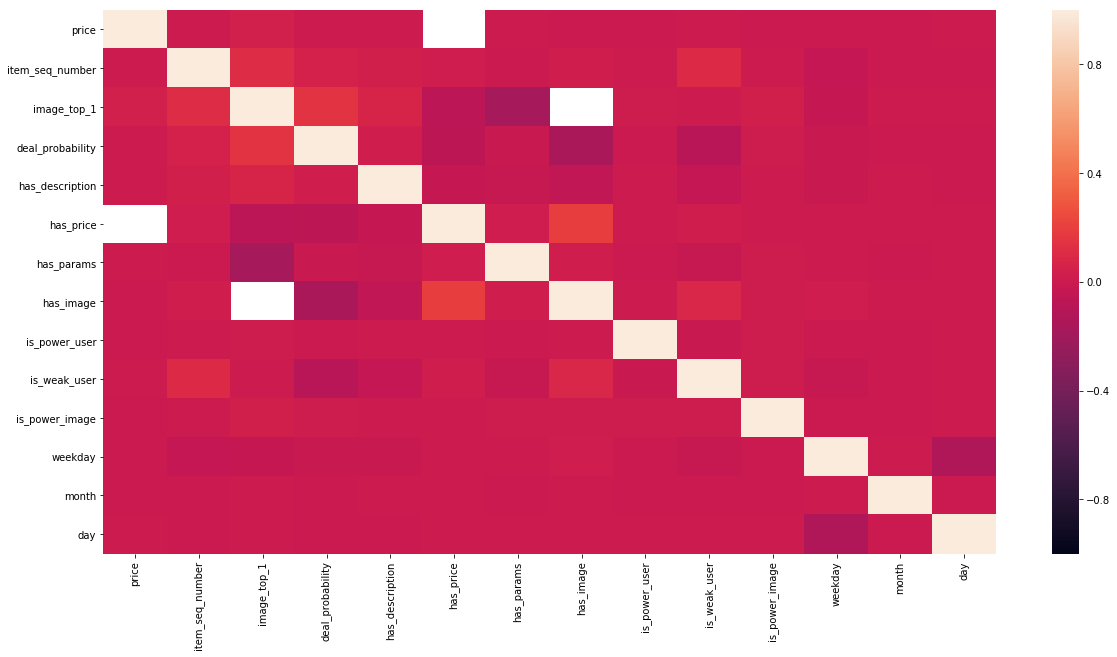

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,0.004270,0.041619,0.001724,0.001439,NaN,0.000597,-0.005272,-0.000047,0.000135,-0.000085,-0.001234,-0.000005,0.000105
item_seq_number,0.004270,1.000000,0.112072,0.049279,0.035474,0.018698,-0.003494,0.025890,0.001389,0.094949,0.002233,-0.034257,-0.000220,-0.005601
image_top_1,0.041619,0.112072,1.000000,0.148034,0.069776,-0.075605,-0.175275,NaN,0.009496,0.000560,0.038187,-0.030207,0.002683,0.006735
deal_probability,0.001724,0.049279,0.148034,1.000000,0.028695,-0.067074,-0.008842,-0.153100,-0.002537,-0.091197,0.008501,-0.013200,-0.000649,-0.003342
has_description,0.001439,0.035474,0.069776,0.028695,1.000000,-0.025542,-0.021355,-0.047737,0.004664,-0.034780,0.005973,-0.013734,0.000494,-0.004488
has_price,NaN,0.018698,-0.075605,-0.067074,-0.025542,1.000000,0.020436,0.190576,0.000010,0.030528,0.000382,0.006981,0.000342,0.001878
has_params,0.000597,-0.003494,-0.175275,-0.008842,-0.021355,0.020436,1.000000,0.031109,-0.000563,-0.021126,0.008091,0.002208,-0.002479,0.000131
has_image,-0.005272,0.025890,NaN,-0.153100,-0.047737,0.190576,0.031109,1.000000,0.002755,0.082260,0.015305,0.016861,0.000411,0.001118
is_power_user,-0.000047,0.001389,0.009496,-0.002537,0.004664,0.000010,-0.000563,0.002755,1.000000,-0.009168,0.011964,-0.002173,-0.000039,0.003128
is_weak_user,0.000135,0.094949,0.000560,-0.091197,-0.034780,0.030528,-0.021126,0.082260,-0.009168,1.000000,0.010443,-0.015868,-0.000595,0.005753


Spearman correlation:


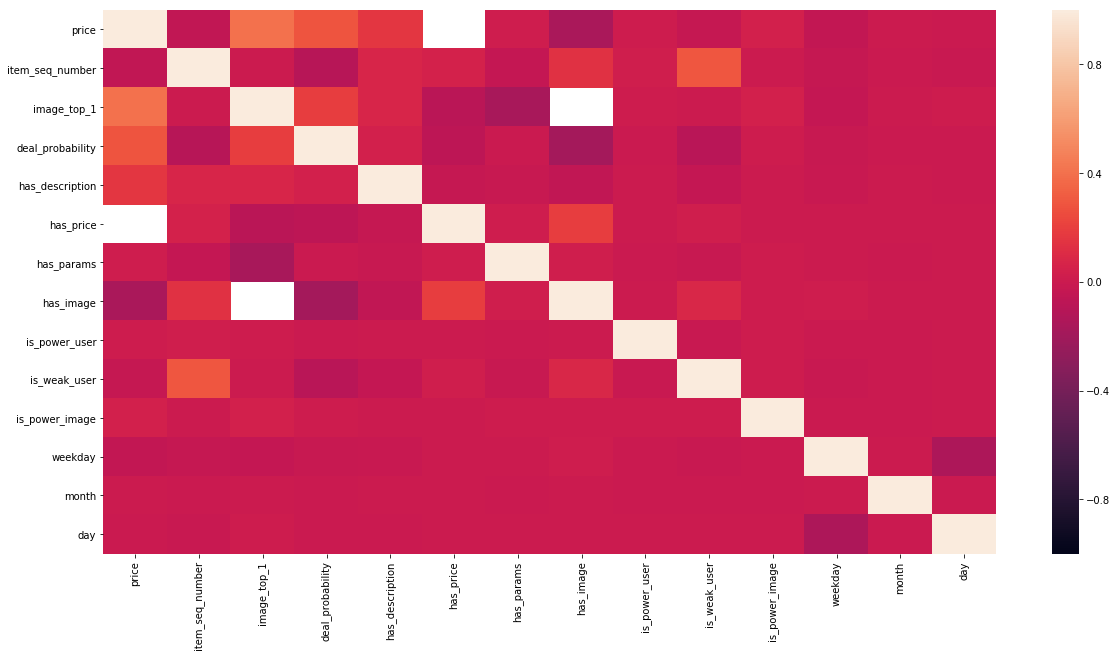

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,-0.048829,0.400841,0.282204,0.157619,NaN,0.017714,-0.157547,0.008154,-0.030812,0.041870,-0.045623,0.001920,-0.004697
item_seq_number,-0.048829,1.000000,0.005021,-0.097597,0.076446,0.048336,-0.035177,0.139285,0.025709,0.293758,0.006513,-0.027833,-0.000714,-0.009554
image_top_1,0.400841,0.005021,1.000000,0.194986,0.071052,-0.080253,-0.169615,NaN,0.010526,0.002439,0.044492,-0.031432,0.002379,0.008076
deal_probability,0.282204,-0.097597,0.194986,1.000000,0.044781,-0.066049,-0.003954,-0.182008,-0.003011,-0.089032,0.009417,-0.022367,-0.000717,-0.000917
has_description,0.157619,0.076446,0.071052,0.044781,1.000000,-0.025542,-0.021355,-0.047737,0.004664,-0.034780,0.005973,-0.013455,0.000494,-0.004246
has_price,NaN,0.048336,-0.080253,-0.066049,-0.025542,1.000000,0.020436,0.190576,0.000010,0.030528,0.000382,0.006792,0.000342,0.001731
has_params,0.017714,-0.035177,-0.169615,-0.003954,-0.021355,0.020436,1.000000,0.031109,-0.000563,-0.021126,0.008091,0.002183,-0.002479,0.000090
has_image,-0.157547,0.139285,NaN,-0.182008,-0.047737,0.190576,0.031109,1.000000,0.002755,0.082260,0.015305,0.016701,0.000411,0.000903
is_power_user,0.008154,0.025709,0.010526,-0.003011,0.004664,0.000010,-0.000563,0.002755,1.000000,-0.009168,0.011964,-0.002184,-0.000039,0.003149
is_weak_user,-0.030812,0.293758,0.002439,-0.089032,-0.034780,0.030528,-0.021126,0.082260,-0.009168,1.000000,0.010443,-0.015461,-0.000595,0.006107


Kendal-tau correlation:


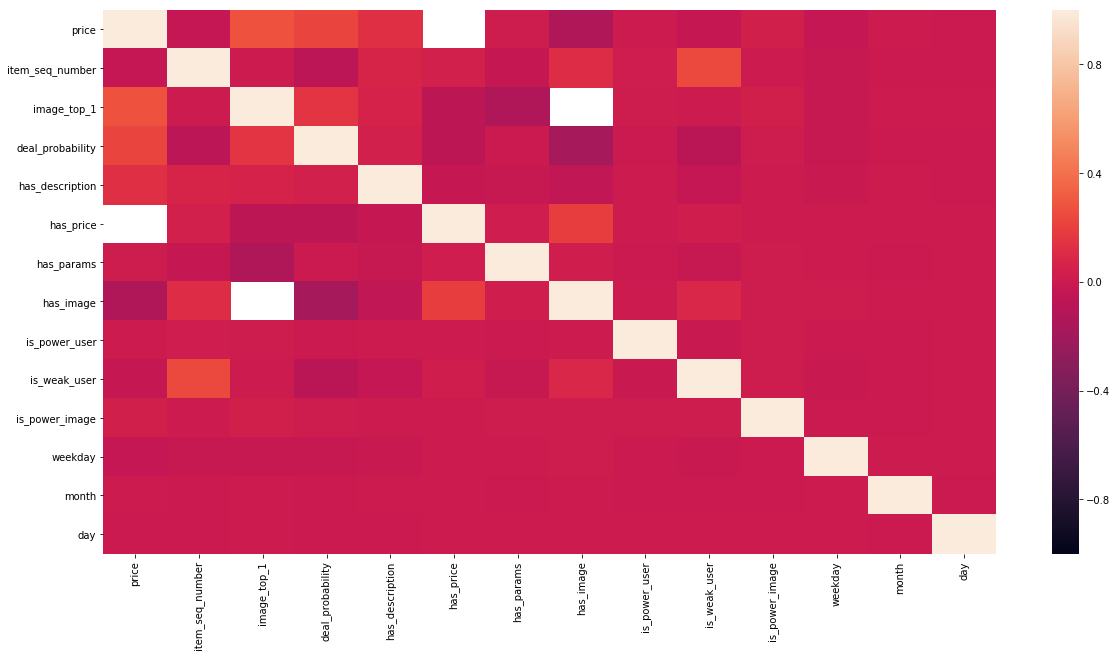

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,-0.037059,0.275345,0.222487,0.130219,NaN,0.014634,-0.130159,0.006736,-0.025456,0.034591,-0.032928,0.001586,-0.003288
item_seq_number,-0.037059,1.000000,0.001902,-0.075531,0.062765,0.039686,-0.028882,0.114359,0.021108,0.241188,0.005347,-0.020022,-0.000586,-0.006659
image_top_1,0.275345,0.001902,1.000000,0.153580,0.058080,-0.065602,-0.138650,NaN,0.008604,0.001994,0.036369,-0.022412,0.001944,0.005593
deal_probability,0.222487,-0.075531,0.153580,1.000000,0.042915,-0.063296,-0.003789,-0.174423,-0.002885,-0.085321,0.009025,-0.018701,-0.000687,-0.000737
has_description,0.130219,0.062765,0.058080,0.042915,1.000000,-0.025542,-0.021355,-0.047737,0.004664,-0.034780,0.005973,-0.011747,0.000494,-0.003589
has_price,NaN,0.039686,-0.065602,-0.063296,-0.025542,1.000000,0.020436,0.190576,0.000010,0.030528,0.000382,0.005929,0.000342,0.001463
has_params,0.014634,-0.028882,-0.138650,-0.003789,-0.021355,0.020436,1.000000,0.031109,-0.000563,-0.021126,0.008091,0.001906,-0.002479,0.000076
has_image,-0.130159,0.114359,NaN,-0.174423,-0.047737,0.190576,0.031109,1.000000,0.002755,0.082260,0.015305,0.014581,0.000411,0.000764
is_power_user,0.006736,0.021108,0.008604,-0.002885,0.004664,0.000010,-0.000563,0.002755,1.000000,-0.009168,0.011964,-0.001907,-0.000039,0.002662
is_weak_user,-0.025456,0.241188,0.001994,-0.085321,-0.034780,0.030528,-0.021126,0.082260,-0.009168,1.000000,0.010443,-0.013499,-0.000595,0.005162


In [63]:
print('deal_class_1 percentage of values: ', len(deal_class_1)/train.shape[0]*100, 'and mean price is: ', deal_class_1['price'].mean())
print('Pearson correlation:')
corr = deal_class_1.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Spearman correlation:')
corr = deal_class_1.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Kendal-tau correlation:')
corr = deal_class_1.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

deal_class_2 percentage of values:  8.422241496743434 and mean price is:  326402.8185227325
Pearson correlation:


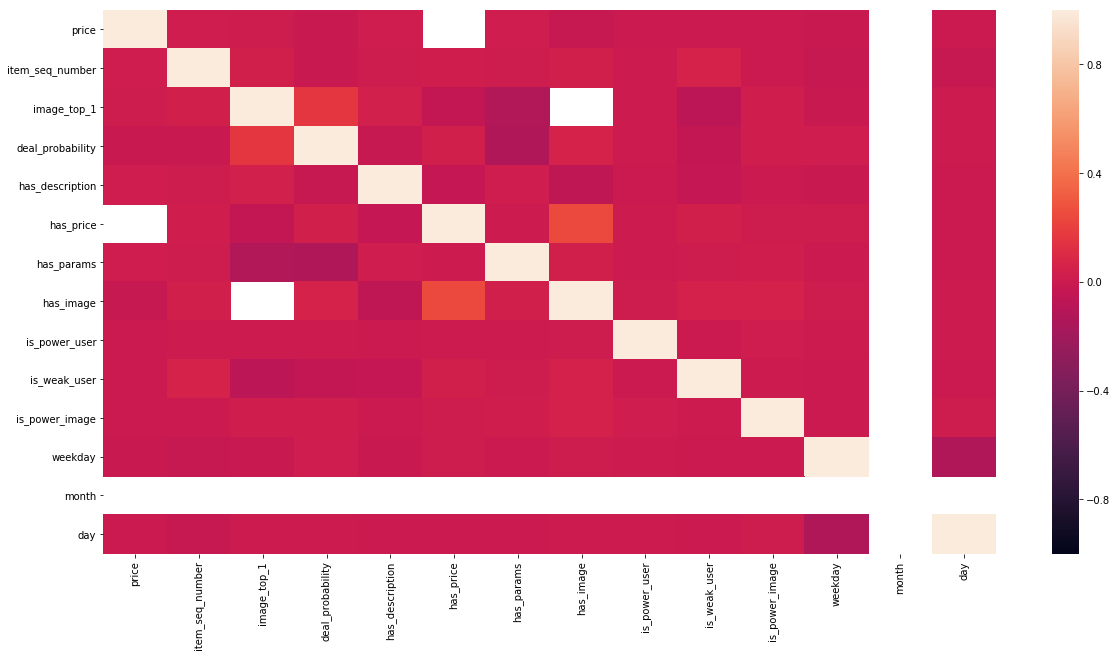

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,0.019088,0.012467,-0.008782,0.019013,NaN,0.017152,-0.019762,-0.001371,-0.002454,-0.006921,-0.011210,NaN,-0.002368
item_seq_number,0.019088,1.000000,0.038672,-0.013224,0.015230,0.029486,0.012964,0.037878,0.000889,0.058885,-0.002523,-0.018762,NaN,-0.017104
image_top_1,0.012467,0.038672,1.000000,0.158480,0.040064,-0.044301,-0.123131,NaN,0.000498,-0.075000,0.027478,-0.008426,NaN,0.001730
deal_probability,-0.008782,-0.013224,0.158480,1.000000,-0.021104,0.034914,-0.128193,0.059811,0.005491,-0.045304,0.028326,0.015880,NaN,0.003184
has_description,0.019013,0.015230,0.040064,-0.021104,1.000000,-0.035838,0.016402,-0.061123,-0.002151,-0.034923,-0.003552,-0.013341,NaN,-0.007338
has_price,NaN,0.029486,-0.044301,0.034914,-0.035838,1.000000,0.005724,0.236338,0.007553,0.035326,0.012637,0.014518,NaN,-0.003166
has_params,0.017152,0.012964,-0.123131,-0.128193,0.016402,0.005724,1.000000,0.031409,0.004633,0.013126,0.027016,-0.007437,NaN,-0.003361
has_image,-0.019762,0.037878,NaN,0.059811,-0.061123,0.236338,0.031409,1.000000,0.011977,0.049857,0.050814,0.014083,NaN,0.003744
is_power_user,-0.001371,0.000889,0.000498,0.005491,-0.002151,0.007553,0.004633,0.011977,1.000000,-0.003815,0.017308,0.005160,NaN,0.007348
is_weak_user,-0.002454,0.058885,-0.075000,-0.045304,-0.034923,0.035326,0.013126,0.049857,-0.003815,1.000000,0.000256,-0.000493,NaN,-0.002927


Spearman correlation:


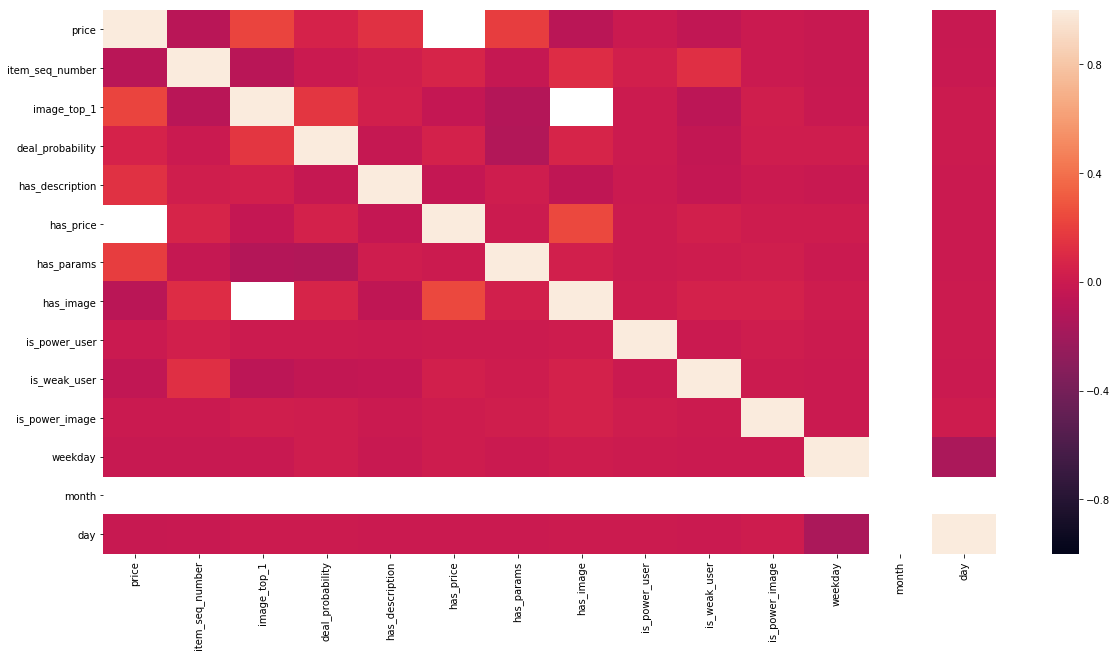

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,-0.089926,0.226006,0.060309,0.140322,NaN,0.193003,-0.080124,-0.001396,-0.051405,-0.006732,-0.023387,NaN,-0.018809
item_seq_number,-0.089926,1.000000,-0.092250,-0.003223,0.025607,0.068209,-0.025878,0.114654,0.034322,0.131779,-0.002517,-0.017694,NaN,-0.014671
image_top_1,0.226006,-0.092250,1.000000,0.156394,0.038705,-0.035330,-0.113335,NaN,0.000242,-0.070824,0.026510,-0.009356,NaN,0.000945
deal_probability,0.060309,-0.003223,0.156394,1.000000,-0.025858,0.053831,-0.122358,0.064768,0.006338,-0.043243,0.017393,0.017854,NaN,0.002750
has_description,0.140322,0.025607,0.038705,-0.025858,1.000000,-0.035838,0.016402,-0.061123,-0.002151,-0.034923,-0.003552,-0.012854,NaN,-0.007127
has_price,NaN,0.068209,-0.035330,0.053831,-0.035838,1.000000,0.005724,0.236338,0.007553,0.035326,0.012637,0.014322,NaN,-0.003327
has_params,0.193003,-0.025878,-0.113335,-0.122358,0.016402,0.005724,1.000000,0.031409,0.004633,0.013126,0.027016,-0.007216,NaN,-0.003244
has_image,-0.080124,0.114654,NaN,0.064768,-0.061123,0.236338,0.031409,1.000000,0.011977,0.049857,0.050814,0.013740,NaN,0.003573
is_power_user,-0.001396,0.034322,0.000242,0.006338,-0.002151,0.007553,0.004633,0.011977,1.000000,-0.003815,0.017308,0.005145,NaN,0.007344
is_weak_user,-0.051405,0.131779,-0.070824,-0.043243,-0.034923,0.035326,0.013126,0.049857,-0.003815,1.000000,0.000256,-0.000318,NaN,-0.002850


Kendal-tau correlation:


KeyboardInterrupt: 

In [64]:
print('deal_class_2 percentage of values: ', len(deal_class_2)/train.shape[0]*100, 'and mean price is: ', deal_class_2['price'].mean())
print('Pearson correlation:')
corr = deal_class_2.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Spearman correlation:')
corr = deal_class_2.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Kendal-tau correlation:')
corr = deal_class_2.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

In [ ]:
print('deal_class_3 percentage of values: ', len(deal_class_3)/train.shape[0]*100, 'and mean price is: ', deal_class_3['price'].mean())
print('Pearson correlation:')
corr = deal_class_3.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Spearman correlation:')
corr = deal_class_3.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Kendal-tau correlation:')
corr = deal_class_3.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

In [ ]:
print('deal_class_4 percentage of values: ', len(deal_class_4)/train.shape[0]*100, 'and mean price is: ', deal_class_4['price'].mean())
print('Pearson correlation:')
corr = deal_class_4.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Spearman correlation:')
corr = deal_class_4.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Kendal-tau correlation:')
corr = deal_class_4.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

In [ ]:
print('deal_class_5 percentage of values: ', len(deal_class_5)/train.shape[0]*100, 'and mean price is: ', deal_class_5['price'].mean())
print('Pearson correlation:')
corr = deal_class_5.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Spearman correlation:')
corr = deal_class_5.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)
print('Kendal-tau correlation:')
corr = deal_class_5.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

First we notice that 80% of the items have very low deal probability(0-0.2).

We can see that as the probability increases - the mean price drops significantly (which is reasonable).

We can also see that there is an interesting correlation between the image_top_1 feature and the target variable which is the highest(0.4) for the class of 0.8-1.0 deal probability.

There is also some correlation between the price feature and the target variable and it is different between the classes - for the lowest probability class and the highest probability class it is positive (0.21,0.1), for the second and third class it is close to 0 and for the 4th class it is strictly negative(-0.27).

We can also see some mostly negative correlation between the item_seq_number,has_params/image/description/price features and the target variable in the highest probability class.

Finally we can see that there is a constant correlation of about 0.2 between has_price and has_image.

## Data Exploration

### Feature correlation

Pearson correlation:

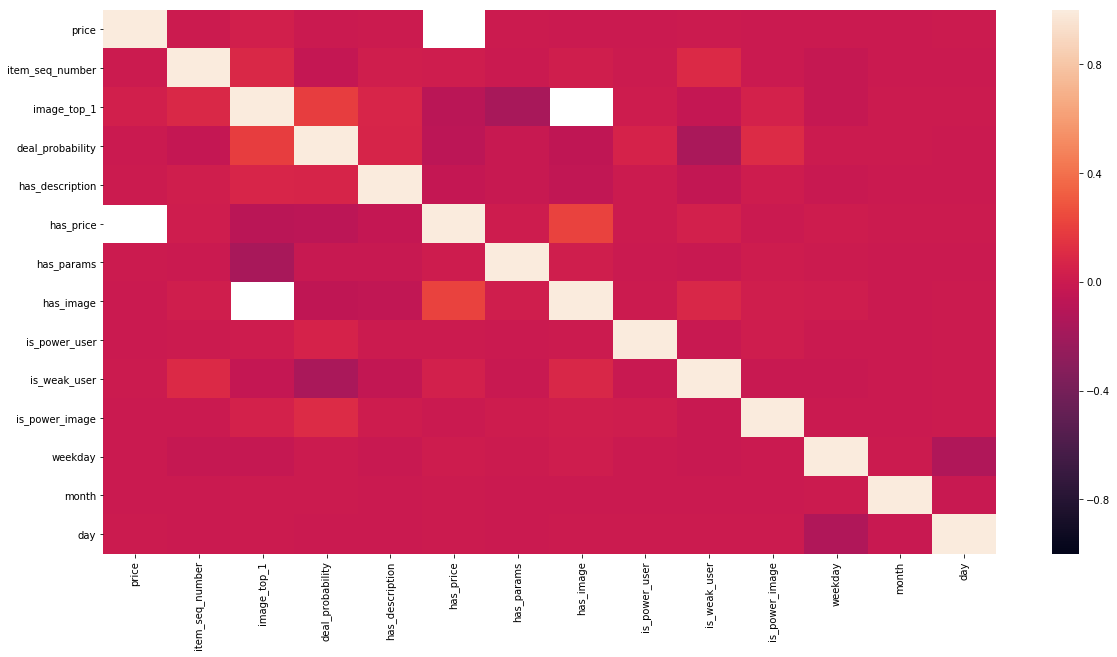

,price,item_seq_number,image_top_1,deal_probability,has_description,has_price,has_params,has_image,is_power_user,is_weak_user,is_power_image,weekday,month,day
price,1.000000,0.004246,0.034404,-0.001097,0.001362,NaN,0.000661,-0.004528,-0.000104,0.000305,-0.000264,-0.001174,-0.000009,0.000081
item_seq_number,0.004246,1.000000,0.091472,-0.035744,0.029805,0.022051,-0.001265,0.028060,0.002987,0.098150,-0.003625,-0.031065,-0.000192,-0.005955
image_top_1,0.034404,0.091472,1.000000,0.189979,0.075407,-0.078916,-0.170344,NaN,0.014996,-0.034213,0.050039,-0.024776,0.001504,0.005849
deal_probability,-0.001097,-0.035744,0.189979,1.000000,0.070184,-0.071770,-0.016951,-0.056723,0.058472,-0.158277,0.101806,0.002096,0.003555,-0.002379
has_description,0.001362,0.029805,0.075407,0.070184,1.000000,-0.032709,-0.016374,-0.051506,0.007232,-0.044161,0.009251,-0.013075,-0.000309,-0.004407
has_price,NaN,0.022051,-0.078916,-0.071770,-0.032709,1.000000,0.015529,0.215760,0.000172,0.042080,-0.000143,0.010243,0.000600,0.000236
has_params,0.000661,-0.001265,-0.170344,-0.016951,-0.016374,0.015529,1.000000,0.030840,-0.001069,-0.012462,0.014342,0.000989,-0.000866,-0.000352
has_image,-0.004528,0.028060,NaN,-0.056723,-0.051506,0.215760,0.030840,1.000000,0.007551,0.081956,0.024548,0.017421,-0.000337,0.001337
is_power_user,-0.000104,0.002987,0.014996,0.058472,0.007232,0.000172,-0.001069,0.007551,1.000000,-0.012874,0.018906,-0.000643,-0.000096,0.003175
is_weak_user,0.000305,0.098150,-0.034213,-0.158277,-0.044161,0.042080,-0.012462,0.081956,-0.012874,1.000000,-0.007979,-0.013675,-0.000799,0.005291


In [65]:
corr = train.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

Spearman correlation:

In [66]:
corr = train.corr('spearman')
sns.heatmap(corr, vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

KeyboardInterrupt: 

Kendall-tau correlation:

In [ ]:
corr = train.corr('kendall')
sns.heatmap(corr, vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

Mutual Information:

In [76]:
partial_train = train[:50000]

In [77]:
price_mutual_info = metrics.adjusted_mutual_info_score(partial_train['price'], partial_train['deal_probability'])
print('price MI:',price_mutual_info)

price MI: 0.07028882637045923


In [78]:
item_seq_number_mutual_info = metrics.adjusted_mutual_info_score(partial_train['item_seq_number'], partial_train['deal_probability'])
print('item_seq_number MI:',item_seq_number_mutual_info)

item_seq_number MI: -0.008528054284717597


In [79]:
image_top_1_mutual_info = metrics.adjusted_mutual_info_score(partial_train['image_top_1'], partial_train['deal_probability'])
print('image_top_1 MI:',image_top_1_mutual_info)

image_top_1 MI: 0.04991963671167028


In [80]:
is_power_user_mutual_info = metrics.adjusted_mutual_info_score(partial_train['is_power_user'], partial_train['deal_probability'])
print('is_power_user MI:',is_power_user_mutual_info)

is_power_user MI: 0.00019848383283286222


In [81]:
is_weak_user_mutual_info = metrics.adjusted_mutual_info_score(partial_train['is_weak_user'], partial_train['deal_probability'])
print('is_weak_user MI:',is_weak_user_mutual_info)

is_weak_user MI: 0.003735611732327429


# <span style="color:blue">train_active.csv</span>

# <span style="color:blue">periods_train.csv</span>